# Habitat suitability under climate change

[Our changing climate is changing where key grassland species can live,
and grassland management and restoration practices will need to take
this into
account.](https://www.frontiersin.org/articles/10.3389/fpls.2017.00730/full)

In this coding challenge, you will create a habitat suitability model
for a species of your choice that lives in the continental United States
(CONUS). We have this limitation because the downscaled climate data we
suggest, the [MACAv2 dataset](https://www.climatologylab.org/maca.html),
is only available in the CONUS – if you find other downscaled climate
data at an appropriate resolution you are welcome to choose a different
study area. If you don’t have anything in mind, you can take a look at
Sorghastrum nutans, a grass native to North America. [In the past 50
years, its range has moved
northward](https://www.gbif.org/species/2704414).

Your suitability assessment will be based on combining multiple data
layers related to soil, topography, and climate. You will also need to
create a **modular, reproducible, workflow** using functions and loops.
To do this effectively, we recommend planning your code out in advance
using a technique such as pseudocode outline or a flow diagram. We
recommend planning each of the blocks below out into multiple steps. It
is unnecessary to write a step for every line of code unles you find
that useful. As a rule of thumb, aim for steps that cover the major
structures of your code in 2-5 line chunks.

## STEP 1: STUDY OVERVIEW

Before you begin coding, you will need to design your study.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>What question do you hope to answer about potential future changes in
habitat suitability?</p></div></div>

Western Wheatgrass, or Pascopyrum smithii, is a common, dominant grass species in Colorado grasslands. 

Sources:
1) https://plants.usda.gov/DocumentLibrary/factsheet/pdf/fs_pasm.pdf

YOUR QUESTION HERE

In [1]:
pip install pygbif

Note: you may need to restart the kernel to use updated packages.


In [2]:
### load packages

import os
from glob import glob
import pathlib

### reproducible file paths

### gbif packages
import pygbif.occurrences as occ
import pygbif.species as species
from getpass import getpass

### packages for unzipping and handling gbif data
import zipfile
import time

### deal with spatial data
import geopandas as gpd
import xrspatial

### deal with other types of data
import numpy as np
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rxrm

### indalid geometries
from shapely.geometry import MultiPolygon, Polygon

### visualizing
import holoviews as hv
import hvplot.pandas
import hvplot.xarray

c:\Users\moenc\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
### Make reproducible file paths
data_dir = os.path.join(
	### home directory
	pathlib.Path.home(),
	
	### eda directory
	'earth-analytics',
	'data',

	### Project dir
	'hab_suit'
)

### make the dir
os.makedirs(data_dir, exist_ok=True)


In [4]:
### set gbif dir
gbif_dir = os.path.join(data_dir, 'gbif_ponderosa')


### access gbif
reset_credentials=True

### enter gbif username, password, email
credentials=dict(
	GBIF_USER=(input, 'GBIF username:'),
	GBIF_PWD=(getpass, 'GBIF password'),
	GBIF_EMAIL=(input, 'GBIF email')
)
for env_variable, (prompt_func, prompt_text) in credentials.items():

	### delete credential from the environment
	if reset_credentials and (env_variable in os.environ):
		os.environ.pop(env_variable)

	### ask for credential and save to environment
	if not env_variable in os.environ:
		os.environ[env_variable] = prompt_func(prompt_text)



In [5]:
### species names
species_name = 'Pascopyrum smithii'

### species info for gbif
species_info = species.name_lookup(species_name,
					rank = 'SPECIES')

### grab the first resule
first_result = species_info['results'][0]

### get species key
species_key = first_result['nubKey']

### check on that
first_result['species'], species_key



('Pascopyrum smithii', 2705772)

In [6]:
### assign species code
species_key = 7908414

In [7]:
### set a file pattern
gbif_pattern = os.path.join(gbif_dir,
				'*.csv')

In [8]:
### download it once:
if not glob(gbif_pattern):

	### submit my query to GBIF
	gbif_query = occ.download([
	f"speciesKey = {species_key}",
	"hasCoordinate = True",
	])


### only download once
	if not 'GBIF_DOWNLOAD_KEY' in os.environ:
		os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]
		download_key=os.environ['GBIF_DOWNLOAD_KEY']

	### wait for download to build
		wait = occ.download_meta(download_key)['status']
		time.sleep(5)

	### download the data
	download_info = occ.download_get(
		os.environ['GBIF_DOWNLOAD_KEY'],
		path = data_dir
	)

### unzip it
with zipfile.ZipFile(download_info['path']) as download_zip:
	download_zip.extractall(path = gbif_dir)


### find csv file path
gbif_path = glob(gbif_pattern)[0]


Exception: error: , with error status code 401check your number of active downloads.

In [ ]:
### download it once:
if not glob(gbif_pattern):

	### submit my query to GBIF
	gbif_query = occ.download([
	f"speciesKey = {species_key}",
	"hasCoordinate = True",
	])

	### only download once
	if not 'GBIF_DOWNLOAD_KEY' in os.environ:
		os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]
		download_key=os.environ['GBIF_DOWNLOAD_KEY']

		### wait for download to build
		wait = occ.download_meta(download_key)['status']
		time.sleep(5)

		### download the data
		download_info = occ.download_get(
			os.environ['GBIF_DOWNLOAD_KEY'],
			path = data_dir
	)

### unzip it
with zipfile.ZipFile(download_info['path']) as download_zip:
	download_zip.extractall(path = gbif_dir)


### find csv file path
gbif_path = glob(gbif_pattern)[0]


NameError: name 'glob' is not defined

INFO:Created 20 records


<Axes: >

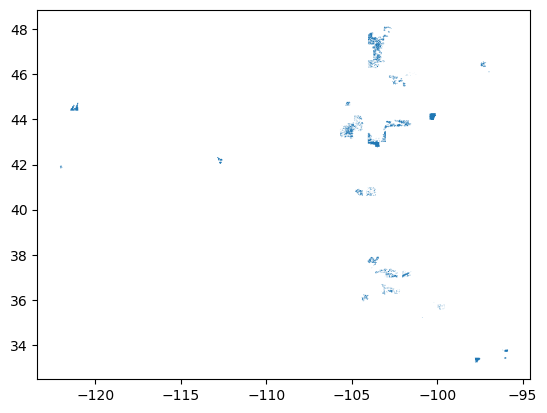

In [9]:
# Define info for grasslands download
grasslands_url = (
    "https://data.fs.usda.gov/geodata/edw/edw_resources/"
    "shp/S_USA.NationalGrassland.zip"
)
grasslands_dir = os.path.join(data_dir, 'grasslands')
os.makedirs(grasslands_dir, exist_ok=True)
grasslands_path = os.path.join(grasslands_dir, 'grasslands.shp')

# Only download once
if not os.path.exists (grasslands_path):
    grasslands_gdf = gpd.read_file(grasslands_url)
    grasslands_gdf.to_file(grasslands_path)

# Load from file
grasslands_gdf = gpd.read_file(grasslands_path)

# Check the data
grasslands_gdf.plot()

In [10]:
# Print the full grasslands_gdf. Note the NATIONALGR column. 
grasslands_gdf

,NATIONALGR,GRASSLANDN,GIS_ACRES,SHAPE_AREA,SHAPE_LEN,geometry
0,281771010328,Fort Pierre National Grassland,209044.225,0.095149,1.455518,"POLYGON ((-100.08409 44.28162, -100.08409 44.2..."
1,295507010328,Butte Valley National Grassland,19489.170,0.008557,0.853736,"MULTIPOLYGON (((-121.996 41.84049, -121.996 41..."
2,295508010328,Kiowa National Grassland,144281.321,0.058543,9.858642,"MULTIPOLYGON (((-104.30414 36.08063, -104.3041..."
3,295509010328,Sheyenne National Grassland,70428.175,0.033356,4.097398,"MULTIPOLYGON (((-97.31081 46.51457, -97.30559 ..."
4,295510010328,Cedar River National Grassland,6717.517,0.003157,0.999947,"MULTIPOLYGON (((-101.82221 45.95896, -101.8170..."
5,295511010328,Black Kettle National Grassland,33103.349,0.013340,4.561060,"MULTIPOLYGON (((-99.91659 35.71892, -99.91661 ..."
6,295512010328,Rita Blanca National Grassland,94127.091,0.038271,6.652113,"MULTIPOLYGON (((-102.62993 36.44072, -102.6298..."
7,295513010328,Thunder Basin National Grassland,626249.208,0.282888,44.088050,"MULTIPOLYGON (((-105.46005 43.31908, -105.4601..."
8,295514010328,McClellan Creek National Grassland,1401.715,0.000562,0.115902,"POLYGON ((-100.86003 35.20951, -100.86008 35.2..."
9,295515010328,Caddo National Grassland,68479.549,0.026940,1.159342,"MULTIPOLYGON (((-95.85492 33.79814, -95.85494 ..."


In [12]:
# Define and print the boundary for the Pawnee National Grassland, with ESRI imagery as the background. 
# For future runs of this code on different study areas, simply replace the "NATIONALGR" value 
# on the first line below with the corresponding value for the new study area from the table above.

pawnee_gdf = grasslands_gdf[grasslands_gdf.NATIONALGR=='295523010328']
pawnee_gdf.dissolve().hvplot(
    geo=True, tiles='EsriImagery',
    title='Pawnee National Grassland',
    fill_color=None, line_color='black', line_width=1.5,
    frame_width=800
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [13]:
# Define and print the Comanche National Grassland boundary, with ESRI imagery as the background.

comanche_gdf = grasslands_gdf[grasslands_gdf.NATIONALGR=='295522010328']
comanche_gdf.dissolve().hvplot(
    geo=True, tiles='EsriImagery',
    title='Comanche National Grassland',
    fill_color=None, line_color='black', line_width=1.5,
    frame_width=800
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [14]:
%store comanche_gdf pawnee_gdf

Stored 'comanche_gdf' (GeoDataFrame)
Stored 'pawnee_gdf' (GeoDataFrame)


In [15]:
# Import tools
import os
import pathlib #finds the home folder
import pandas as pd
import geopandas as gpd
import matplotlib
import hvplot.pandas
import zipfile
import numpy
import xarray as xr
import rioxarray as rxr
import cartopy as ccrs
import earthaccess
import glob
from glob import glob
from math import floor, ceil

In [16]:
# Load stored gdf's from the previous notebook
%store -r pawnee_gdf comanche_gdf

In [17]:
# Define and format a url template for downloading Pawnee soil tiles
p_soil_url_template = ("http://hydrology.cee.duke.edu/POLARIS/"
                     "PROPERTIES/v1.0/ph/mean/30_60/"
                     "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif")
p_soil_url=p_soil_url_template.format(
    min_lat=40, max_lat=41, min_lon=-105, max_lon=-104)
p_soil_url

# Define and format a url template for downloading comanche soil tile
c_soil_url_template = ("http://hydrology.cee.duke.edu/POLARIS/"
                     "PROPERTIES/v1.0/ph/mean/30_60/"
                     "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif")
c_soil_url=p_soil_url_template.format(
    min_lat=36, max_lat=38, min_lon=-104, max_lon=-102)
c_soil_url

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat3638_lon-104-102.tif'

### Species

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Select the species you want to study, and research it’s habitat
parameters in scientific studies or other reliable sources. You will
want to look for reviews or overviews of the data, since an individual
study may not have the breadth needed for this purpose. In the US, the
National Resource Conservation Service can have helpful fact sheets
about different species. University Extension programs are also good
resources for summaries.</p>
<p>Based on your research, select soil, topographic, and climate
variables that you can use to determine if a particular location and
time period is a suitable habitat for your species.</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Write a description of your species. What habitat is it found in?
What is its geographic range? What, if any, are conservation threats to
the species? What data will shed the most light on habitat suitability
for this species?</p></div></div>

YOUR SPECIES DESCRIPTION HERE

### Sites

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Select at least two site to study, such as two of the U.S. National
Grasslands. You can download the <a
href="https://data.fs.usda.gov/geodata/edw/edw_resources/shp/S_USA.NationalGrassland.zip">USFS
National Grassland Units</a> and select your study sites. Generate a
site map for each location.</p>
<p>When selecting your sites, you might want to look for places that are
marginally habitable for this species, since those locations will be
most likely to show changes due to climate.</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Write a site description for each of your sites, or for all of your
sites as a group if you have chosen a large number of linked sites. What
differences or trends do you expect to see among your sites?</p></div></div>

YOUR SITE DESCRIPTION HERE

### Time periods

In general when studying climate, we are interested in **climate
normals**, which are typically calculated from 30 years of data so that
they reflect the climate as a whole and not a single year which may be
anomalous. So if you are interested in the climate around 2050, download
at least data from 2035-2065.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Select at least two 30-year time periods to compare, such as
historical and 30 years into the future. These time periods should help
you to answer your scientific question.</p></div></div>

YOUR TIME PERIODS HERE

### Climate models

There is a great deal of uncertainty among the many global climate
models available. One way to work with the variety is by using an
**ensemble** of models to try to capture that uncertainty. This also
gives you an idea of the range of possible values you might expect! To
be most efficient with your time and computing resources, you can use a
subset of all the climate models available to you. However, for each
scenario, you should attempt to include models that are:

-   Warm and wet
-   Warm and dry
-   Cold and wet
-   Cold and dry

for each of your sites.

To figure out which climate models to use, you will need to access
summary data near your sites for each of the climate models. You can do
this using the [Climate Futures Toolbox Future Climate Scatter
tool](https://climatetoolbox.org/tool/Future-Climate-Scatter). There is
no need to write code to select your climate models, since this choice
is something that requires your judgement and only needs to be done
once.

If your question requires it, you can also choose to include multiple
climate variables, such as temperature and precipitation, and/or
multiple emissions scenarios, such as RCP4.5 and RCP8.5.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Choose at least 4 climate models that cover the range of possible
future climate variability at your sites. How did you choose?</p></div></div>

LIST THE CLIMATE MODELS YOU SELECTED HERE AND CITE THE CLIMATE TOOLBOX

## STEP 2: DATA ACCESS

### Soil data

The [POLARIS dataset](http://hydrology.cee.duke.edu/POLARIS/) is a
convenient way to uniformly access a variety of soil parameters such as
pH and percent clay in the US. It is available for a range of depths (in
cm) and split into 1x1 degree tiles.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Write a <strong>function with a numpy-style docstring</strong> that
will download POLARIS data for a particular location, soil parameter,
and soil depth. Your function should account for the situation where
your site boundary crosses over multiple tiles, and merge the necessary
data together.</p>
<p>Then, use loops to download and organize the rasters you will need to
complete this section. Include soil parameters that will help you to
answer your scientific question. We recommend using a soil depth that
best corresponds with the rooting depth of your species.</p></div></div>

In [ ]:
# Download soil data

### Topographic data

One way to access reliable elevation data is from the [SRTM
dataset](https://www.earthdata.nasa.gov/data/instruments/srtm),
available through the [earthaccess
API](https://earthaccess.readthedocs.io/en/latest/quick-start/).

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Write a <strong>function with a numpy-style docstring</strong> that
will download SRTM elevation data for a particular location and
calculate any additional topographic variables you need such as slope or
aspect.</p>
<p>Then, use loops to download and organize the rasters you will need to
complete this section. Include topographic parameters that will help you
to answer your scientific question.</p></div></div>

> **Warning**
>
> Be careful when computing the slope from elevation that the units of
> elevation match the projection units (e.g. meters and meters, not
> meters and degrees). You will need to project the SRTM data to
> complete this calculation correctly.

In [ ]:
# Download soil data

### Climate model data

You can use MACAv2 data for historical and future climate data. Be sure
to compare at least two 30-year time periods (e.g. historical vs. 10
years in the future) for at least four of the CMIP models. Overall, you
should be downloading at least 8 climate rasters for each of your sites,
for a total of 16. **You will *need* to use loops and/or functions to do
this cleanly!**.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Write a <strong>function with a numpy-style docstring</strong> that
will download MACAv2 data for a particular climate model, emissions
scenario, spatial domain, and time frame. Then, use loops to download
and organize the 16+ rasters you will need to complete this section. The
<a
href="http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_CMIP5_macav2_catalog2.html">MACAv2
dataset is accessible from their Thredds server</a>. Include an
arrangement of sites, models, emissions scenarios, and time periods that
will help you to answer your scientific question.</p></div></div>

In [ ]:
# Download climate data

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Make sure to include a description of the climate data and how you
selected your models. Include a citation of the MACAv2 data</p></div></div>

YOUR CLIMATE DATA DESCRIPTION AND CITATIONS HERE

## STEP 3: HARMONIZE DATA

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Make sure that the grids for all your data match each other. Check
out the <a
href="https://corteva.github.io/rioxarray/stable/examples/reproject_match.html#Reproject-Match"><code>ds.rio.reproject_match()</code>
method</a> from <code>rioxarray</code>. Make sure to use the data source
that has the highest resolution as a template!</p></div></div>

> **Warning**
>
> If you are reprojecting data as you need to here, the order of
> operations is important! Recall that reprojecting will typically tilt
> your data, leaving narrow sections of the data at the edge blank.
> However, to reproject efficiently it is best for the raster to be as
> small as possible before performing the operation. We recommend the
> following process:
>
>     1. Crop the data, leaving a buffer around the final boundary
>     2. Reproject to match the template grid (this will also crop any leftovers off the image)

In [ ]:
# Download soil data

## STEP 4: DEVELOP A FUZZY LOGIC MODEL

A fuzzy logic model is one that is built on expert knowledge rather than
training data. You may wish to use the
[`scikit-fuzzy`](https://pythonhosted.org/scikit-fuzzy/) library, which
includes many utilities for building this sort of model. In particular,
it contains a number of **membership functions** which can convert your
data into values from 0 to 1 using information such as, for example, the
maximum, minimum, and optimal values for soil pH.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>To train a fuzzy logic habitat suitability model:</p>
<pre><code>1. Research S. nutans, and find out what optimal values are for each variable you are using (e.g. soil pH, slope, and current climatological annual precipitation). 
2. For each **digital number** in each raster, assign a **continuous** value from 0 to 1 for how close that grid square is to the optimum range (1=optimal, 0=incompatible). 
3. Combine your layers by multiplying them together. This will give you a single suitability number for each square.
4. Optionally, you may apply a suitability threshold to make the most suitable areas pop on your map.</code></pre></div></div>

> **Tip**
>
> If you use mathematical operators on a raster in Python, it will
> automatically perform the operation for every number in the raster.
> This type of operation is known as a **vectorized** function. **DO NOT
> DO THIS WITH A LOOP!**. A vectorized function that operates on the
> whole array at once will be much easier and faster.

In [ ]:
# Create fuzzy logic suitability model

## STEP 5: PRESENT YOUR RESULTS

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Generate some plots that show your key findings. Don’t forget to
interpret your plots!</p></div></div>

In [ ]:
# Create plots

YOUR PLOT INTERPRETATION HERE